In [1]:
"""
Learning to optimize model predictive reference tracking control of a quadcopter
Problem formulation :
    minimize     (x(t)-x_r)^TQ(x(t)-x_r) + u(t)^TRu(t)
    subject to
               x(t+1) = Ax(t) + Bu(t),
               x_lb <= x(t) <= x_ub
               u_lb <= u(t) <= u_ub,

An initial prediction of the solution is made by a neural network,
then a final layer is added to apply a trainable optimization routine for improved solutions.
"""


'\nLearning to optimize model predictive reference tracking control of a quadcopter\nProblem formulation :\n    minimize     (x(t)-x_r)^TQ(x(t)-x_r) + u(t)^TRu(t)\n    subject to\n               x(t+1) = Ax(t) + Bu(t),\n               x_lb <= x(t) <= x_ub\n               u_lb <= u(t) <= u_ub,\n\nAn initial prediction of the solution is made by a neural network,\nthen a final layer is added to apply a trainable optimization routine for improved solutions.\n'

In [2]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase


from LOPO import DRSolver
from LOPO import ADMMSolver
from LOPO import ParaMetricDiagonal

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Quad Copter Model

A = torch.tensor([
    [1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0.],
    [0.0488, 0., 0., 1., 0., 0., 0.0016, 0., 0., 0.0992, 0., 0.],
    [0., -0.0488, 0., 0., 1., 0., 0., -0.0016, 0., 0., 0.0992, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.0992],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    [0.9734, 0., 0., 0., 0., 0., 0.0488, 0., 0., 0.9846, 0., 0.],
    [0., -0.9734, 0., 0., 0., 0., 0., -0.0488, 0., 0., 0.9846, 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.9846]
])
B = torch.tensor([
    [0., -0.0726, 0., 0.0726],
    [-0.0726, 0., 0.0726, 0.],
    [-0.0152, 0.0152, -0.0152, 0.0152],
    [-0., -0.0006, -0., 0.0006],
    [0.0006, 0., -0.0006, 0.0000],
    [0.0106, 0.0106, 0.0106, 0.0106],
    [0, -1.4512, 0., 1.4512],
    [-1.4512, 0., 1.4512, 0.],
    [-0.3049, 0.3049, -0.3049, 0.3049],
    [-0., -0.0236, 0., 0.0236],
    [0.0236, 0., -0.0236, 0.],
    [0.2107, 0.2107, 0.2107, 0.2107]])


# Constraints
u0 = 10.5916

#control constraints will be enforced by sigmoid activation
umin = torch.tensor([9.6, 9.6, 9.6, 9.6]) - u0
umax = torch.tensor([13., 13., 13., 13.]) - u0

#state constraints will be enforced through penalty methods
#constraints are only present on the first two state variables
xmin = torch.tensor([-np.pi / 6, -np.pi / 6]) 
xmax = torch.tensor([np.pi / 6, np.pi / 6])


# Objective function
Q = torch.diag(torch.tensor([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.]))
R = 0.1 * torch.eye(4)


# reference states
#xr = torch.tensor([0, 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.]) #reference point to control to.
xr = torch.tensor([0, 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0.]) #reference point to control to.

# Prediction horizon
N = 10

[nx, nu] = B.shape
n_horizon = N

# neural control policy
mlp = blocks.MLP(nx, nu*n_horizon, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[100, 100, 100, 100])
open_loop_policy = Node(mlp, ['X'], ['U_open_loop'], name='open_loop_policy')
policy_map = lambda OL_U : umin + torch.sigmoid(torch.reshape(OL_U,(OL_U.shape[0],n_horizon,nu)))*(umax - umin)
policy_buffer = Node(policy_map,['U_open_loop'],['U_open_loop_buffer'],name = 'policy_buffer')

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
one_step_dynamics = Node(xnext, ['X', 'U_open_loop_buffer'], ['X'], name='integrator')
ol_system = System([one_step_dynamics])
ol_system.nsteps = n_horizon
#ol_system.show()


In [4]:
# Training dataset generation
angle_scale = 1.0
state_scale = 0.8
x0min = np.array([-angle_scale*np.pi/6, -angle_scale*np.pi/6, -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1., -state_scale*1.])
x0max = np.array([angle_scale*np.pi/6, angle_scale*np.pi/6, state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1., state_scale*1.])

train_samples = 5000
dev_samples = 100
BATCH_SIZE = 100

train_data = DictDataset({'X':torch.unsqueeze(torch.tensor(np.random.uniform(low = x0min, high = x0max,size = (train_samples,len(x0min))),dtype = torch.float32),1)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': torch.unsqueeze(torch.tensor(np.random.uniform(low = x0min, high = x0max,size = (dev_samples,len(x0min))),dtype = torch.float32),1)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=BATCH_SIZE,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

In [5]:
# Define optimization problem
u = variable('U_open_loop_buffer')
x = variable('X')
f =  torch.sum((x-xr)*(x - xr)*torch.diag(Q)) + torch.sum(u*u*torch.diag(R))
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

state_upper_bound_penalty = 100.0*(x[:,:,0:2]<xmax)
state_lower_bound_penalty = 100.0*(x[:,:,0:2]>xmax)
constraints = [state_upper_bound_penalty, state_lower_bound_penalty]

loss = PenaltyLoss(objectives, constraints)
problem = Problem([open_loop_policy,policy_buffer,ol_system], loss)
optimizer = torch.optim.AdamW(open_loop_policy.parameters(), lr=0.001)

In [6]:
#problem.show()

In [7]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=1000,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

best_model = trainer.train()

epoch: 0  train_loss: 76259.3828125
epoch: 1  train_loss: 18066.724609375
epoch: 2  train_loss: 13972.4296875
epoch: 3  train_loss: 12326.9208984375
epoch: 4  train_loss: 11084.3115234375
epoch: 5  train_loss: 10627.5166015625
epoch: 6  train_loss: 10411.259765625
epoch: 7  train_loss: 10275.3154296875
epoch: 8  train_loss: 10168.875
epoch: 9  train_loss: 10035.0771484375
epoch: 10  train_loss: 9909.0654296875
epoch: 11  train_loss: 9714.2333984375
epoch: 12  train_loss: 9870.2998046875
epoch: 13  train_loss: 9500.478515625
epoch: 14  train_loss: 9406.955078125
epoch: 15  train_loss: 9301.2724609375
epoch: 16  train_loss: 9072.849609375
epoch: 17  train_loss: 9316.0673828125
epoch: 18  train_loss: 9190.91796875
epoch: 19  train_loss: 8932.8603515625
epoch: 20  train_loss: 9028.41015625
epoch: 21  train_loss: 8964.662109375
epoch: 22  train_loss: 8931.64453125
epoch: 23  train_loss: 8748.203125
epoch: 24  train_loss: 8777.4619140625
epoch: 25  train_loss: 8845.4462890625
epoch: 26  trai

In [8]:
''' 
Add on Correction
Will assume that variable x is of form
[n_dim*(n_horizon + 1),u_dim*n_horizon,slacks]
'''
Q_x = Q
Q_u = R
'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
def f_obj(x,p):
    x_time = torch.reshape(x[nx:nx*(n_horizon+1)],(n_horizon,nx))
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    return torch.sum((x_time-xr)*torch.squeeze(torch.matmul(Q_x,torch.unsqueeze((x_time-xr),-1)))) + torch.sum(u_time*torch.squeeze(torch.matmul(Q_u,torch.unsqueeze(u_time,-1))))
'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,p):
    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
    x_angle_time = x_time[:,0:2]
    xat_lower_bound = torch.ravel(xmin - x_angle_time)
    xat_upper_bound = torch.ravel(x_angle_time - xmax)
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    u_lower_bound = torch.ravel(umin - u_time)
    u_upper_bound = torch.ravel(u_time - umax)
    return torch.cat((xat_lower_bound,xat_upper_bound,u_lower_bound,u_upper_bound))
def F_eq(x,p):
    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
    x_time_r = x_time[0:-1,:]
    x_time_f = x_time[1:,:]
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    initial_condition = x_time[0,:] - p
    dyn_time = torch.squeeze(torch.matmul(A,torch.unsqueeze(x_time_r,-1))) + torch.squeeze(torch.matmul(B,torch.unsqueeze(u_time,-1))) - x_time_f
    dyn = torch.ravel(dyn_time)
    return torch.cat((initial_condition,dyn))

In [23]:
''' 
Set Problem Parameters
'''
num_steps = 20 # number of solver iterations to take
x_dim = nx*(n_horizon + 1) + nu*n_horizon # dimension of primal variable
n_ineq = 4*(n_horizon + 1) + 2*nu*n_horizon  #number of inequality constraints
n_eq = nx*(n_horizon + 1) #number of equality constraints
parm_dim = nx #number of problem parameters

#Define a metric that will be trained
lb_P = 1e-3
ub_P = 10.0
scl_lb_P = 0.05
scl_ub_P = 0.1
n_dim = x_dim + n_ineq
parm_dim = nx #number of problem parameters
metric = ParaMetricDiagonal(n_dim,parm_dim,ub_P,lb_P,scl_upper_bound=scl_ub_P,scl_lower_bound=scl_lb_P)

''' 
Define Solver
choose either DR or ADMM
'''
solver = 'DR'
#solver = 'ADMM'

if solver == 'DR':
 solver = DRSolver(
     f_obj = f_obj,
     F_ineq = F_ineq,
     F_eq = F_eq,
     x_dim = x_dim, 
     n_ineq = n_ineq,
     n_eq = n_eq, 
     JF_fixed=True,
     Hf_fixed = True,
     num_steps = num_steps,
     metric = metric
     )
if solver == 'ADMM':
    solver = ADMMSolver(
        f_obj = f_obj,
        F_ineq = F_ineq,
        F_eq = F_eq,
        x_dim = x_dim, 
        n_ineq = n_ineq,
        n_eq = n_eq, 
        JF_fixed=True,
        Hf_fixed = True,
        num_steps = num_steps,
        metric = metric
        )
    
# REMAP THROUGH CORRECTION
def solver_map(x,u):
    x_init = x[:,0,:]
    x_cat = torch.reshape(x,(x.shape[0],nx*(n_horizon + 1)))
    u_cat = torch.reshape(u,(u.shape[0],nu*n_horizon))
    return torch.cat((x_cat,u_cat),dim = -1), x_init

solver_mapper = Node(solver_map,['X','U_open_loop_buffer'],['X0_primal','p'],name = 'dr_mapper')
correction = Node(solver,['X0_primal','p'],['X_corrected','cnv_gap'])
components = [open_loop_policy,policy_buffer,ol_system,solver_mapper, correction]

## ADD A CONVERGENCE PENALTY
cnv_gap = variable("cnv_gap")
f_cnv = cnv_gap
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []
#create loss function
loss = PenaltyLoss(objectives, constraints)
#construct constrained optimization problem
problem = Problem(components, loss)

In [24]:
'''
Train correction layer
'''
train_epochs = 5
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=train_epochs,
    patience=500,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()

epoch: 0  train_loss: 22059.2890625
epoch: 1  train_loss: 5646.1982421875
epoch: 2  train_loss: 5203.54638671875
epoch: 3  train_loss: 4769.68310546875
epoch: 4  train_loss: 4487.70263671875
Interrupted training loop.


# EVAULATE Solver OUTPUTS ON DEV SET

In [25]:
td = next(iter(dev_loader))
td = problem(td)

x_corrected = td['dev_X_corrected']
x_time = torch.reshape(x_corrected[:,:nx*(n_horizon+1)],(x_corrected.shape[0],n_horizon+1,nx))
u_time = torch.reshape(x_corrected[:,nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(x_corrected.shape[0],n_horizon,nu))

# we take the control trajectory from the solver (batch,time step, control_dim)
u_solver = u_time
#we take the initial state trajectory, (batch,1, n_dim)
x_initial = x_time[:,0,None,:]
#we pass through the dynamics to construct state trajectory
xnext = lambda z, w: z @ A.T + w @ B.T    
def Dynamics_solution(x_initial,u_sol):
    n_steps = u_sol.shape[1]
    x_n = x_initial
    x_traj = x_initial
    for i in range(n_steps):
        xnew = xnext(x_n,u_sol[:,i,None,:])
        x_n = xnew
        x_traj = torch.cat((x_traj,xnew),dim = 1)
    return x_traj
x_traj = Dynamics_solution(x_initial,u_solver)


In [26]:
''' 
Solve with CVXPY
'''
import cvxpy as cv
import numpy as np
import scipy as sp
from scipy import sparse
from pylab import *
import time

# Discrete time model of a quadcopter
Ad = sparse.csc_matrix([
    [1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0.],
    [0.0488, 0., 0., 1., 0., 0., 0.0016, 0., 0., 0.0992, 0., 0.],
    [0., -0.0488, 0., 0., 1., 0., 0., -0.0016, 0., 0., 0.0992, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.0992],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    [0.9734, 0., 0., 0., 0., 0., 0.0488, 0., 0., 0.9846, 0., 0.],
    [0., -0.9734, 0., 0., 0., 0., 0., -0.0488, 0., 0., 0.9846, 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.9846]
])
Bd = sparse.csc_matrix([
    [0., -0.0726, 0., 0.0726],
    [-0.0726, 0., 0.0726, 0.],
    [-0.0152, 0.0152, -0.0152, 0.0152],
    [-0., -0.0006, -0., 0.0006],
    [0.0006, 0., -0.0006, 0.0000],
    [0.0106, 0.0106, 0.0106, 0.0106],
    [0, -1.4512, 0., 1.4512],
    [-1.4512, 0., 1.4512, 0.],
    [-0.3049, 0.3049, -0.3049, 0.3049],
    [-0., -0.0236, 0., 0.0236],
    [0.0236, 0., -0.0236, 0.],
    [0.2107, 0.2107, 0.2107, 0.2107]])
[nx, nu] = Bd.shape

# Constraints
u0 = 10.5916
uminc = np.array([9.6, 9.6, 9.6, 9.6]) - u0
umaxc = np.array([13., 13., 13., 13.]) - u0
xminc = np.array([-np.pi / 6, -np.pi / 6, -np.inf, -np.inf, -np.inf, -1.,
                 -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf])
xmaxc = np.array([np.pi / 6, np.pi / 6, np.inf, np.inf, np.inf, np.inf,
                 np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# Objective function
Qs = sparse.diags([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.])
QNs = Qs
Rs = 0.1 * sparse.eye(4)

# Initial and reference states
#xrc = np.array([0, 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.])
xrc = np.array([0, 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0.])

# Prediction horizon
N = n_horizon

# Define problem
uc = cv.Variable((nu, N))
xc = cv.Variable((nx, N + 1))
x_init = cv.Parameter(nx)
objectivec = 0
constraintsc = [xc[:, 0] == x_init]
for k in range(N):
    objectivec += cv.quad_form(xc[:, k] - xrc, Qs) + cv.quad_form(uc[:, k], Rs)
    constraintsc += [xc[:, k + 1] == Ad @ xc[:, k] + Bd @ uc[:, k]]
    constraintsc += [ xc[:, k]>=xminc, xc[:, k] <= xmaxc]
    constraintsc += [uminc <= uc[:, k], uc[:, k] <= umaxc]
constraintsc +=[ xc[:, k+1]>=xminc, xc[:, k+1] <= xmaxc]
objectivec += cv.quad_form(xc[:, N] - xrc, QNs)
prob = cv.Problem(cv.Minimize(objectivec), constraintsc)


td = next(iter(dev_loader))
X_inits = td['X'].detach().numpy()
X_cv_sols = []
U_cv_sols = []
for i in range(X_inits.shape[0]):
    x0 = np.ravel(X_inits[i,:,:])
    x_init.value = x0
    prob.solve(solver=cv.OSQP, warm_start=True,verbose = True)
    X_cv_sols.append( np.transpose(xc.value) )
    U_cv_sols.append( np.transpose(uc.value) )

X_cv_sols = np.stack(X_cv_sols)
U_cv_sols = np.stack(U_cv_sols)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 01 09:33:41 PM: Your problem has 172 variables, 53 constraints, and 12 parameters.
(CVXPY) Jul 01 09:33:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 01 09:33:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 01 09:33:41 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 01 09:33:41 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jul 01 09:33:41 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 01 09:33:41 PM: Applying reduction Qp2Symbolic

## Compare Solutions

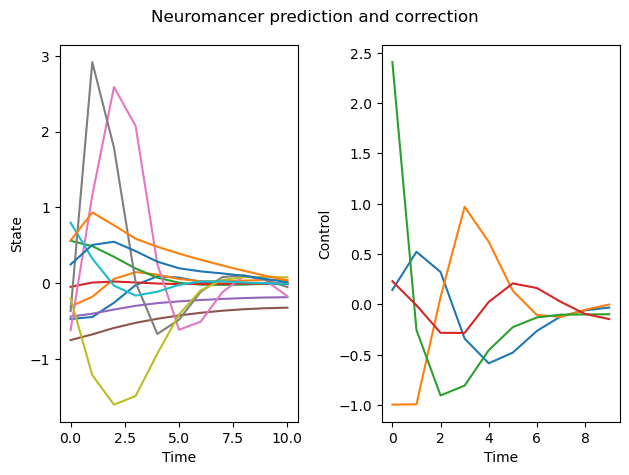

In [27]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(x_traj[0,:,:].detach().numpy())
plt.ylabel('State')
plt.xlabel('Time')
plt.subplot(1,2,2)
plt.plot(u_time[0,:,:].detach().numpy())
plt.ylabel('Control')
plt.xlabel('Time')
plt.suptitle('Neuromancer prediction and correction')
plt.tight_layout()


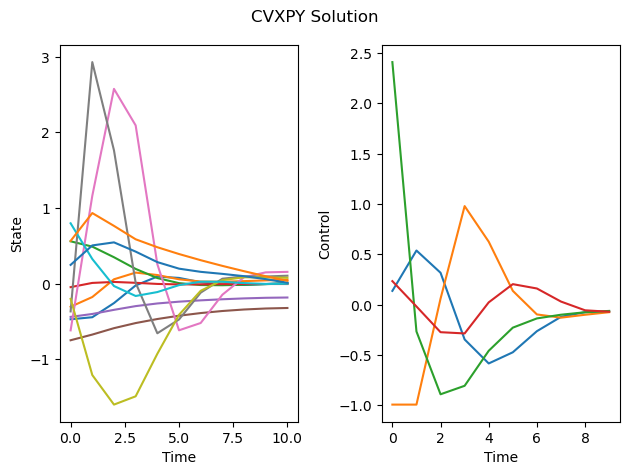

In [28]:
plt.subplot(1,2,1)
plt.plot(X_cv_sols[0,:,:])
plt.ylabel('State')
plt.xlabel('Time')
plt.subplot(1,2,2)
plt.plot(U_cv_sols[0,:,:])
plt.ylabel('Control')
plt.xlabel('Time')
plt.suptitle('CVXPY Solution')
plt.tight_layout()

In [29]:
''' 
Compute difference
'''
xdr = x_time.detach().numpy()
udr = u_time.detach().numpy()

print('Mean relative difference in state traj: ', np.mean(np.sum( np.sum((xdr - X_cv_sols)**2,axis = 2),axis = 1 )/ (np.sum(np.sum(X_cv_sols**2,axis = 2),axis = 1) )) )
print('Mean relative difference in controls: ', np.mean(np.sum( np.sum((udr - U_cv_sols)**2,axis = 2),axis = 1 )/ (np.sum(np.sum(U_cv_sols**2,axis = 2),axis = 1) )) )


Mean relative difference in state traj:  0.011889892881318455
Mean relative difference in controls:  0.023108565283895356
